In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/20
39/39 [==============================] - 22s 471ms/step - loss: 2.4936 - accuracy: 0.6990 - val_loss: 0.5597 - val_accuracy: 0.8903
Epoch 2/20
39/39 [==============================] - 21s 533ms/step - loss: 0.5168 - accuracy: 0.8366 - val_loss: 0.3940 - val_accuracy: 0.8968
Epoch 3/20
39/39 [==============================] - 21s 522ms/step - loss: 0.4270 - accuracy: 0.8447 - val_loss: 0.3032 - val_accuracy: 0.9032
Epoch 4/20
39/39 [==============================] - 20s 511ms/step - loss: 0.3750 - accuracy: 0.8568 - val_loss: 0.2584 - val_accuracy: 0.9065
Epoch 5/20
39/39 [==============================] - 19s 486ms/step - loss: 0.3750 - accuracy: 0.8722 - val_loss: 0.2870 - val_accuracy: 0.9065
Epoch 6/20
39/39 [==============================] - 21s 532ms/step - loss: 0.3540 - accuracy: 0.8746 - val_loss: 0.2649 - val_accuracy: 0.8935
Epoch 7/20
39/39 [==============================] - 21s 537ms/step - loss: 0.3260 - accuracy: 0.8786 - val_loss: 0.2377 - val_accuracy: 0.9097

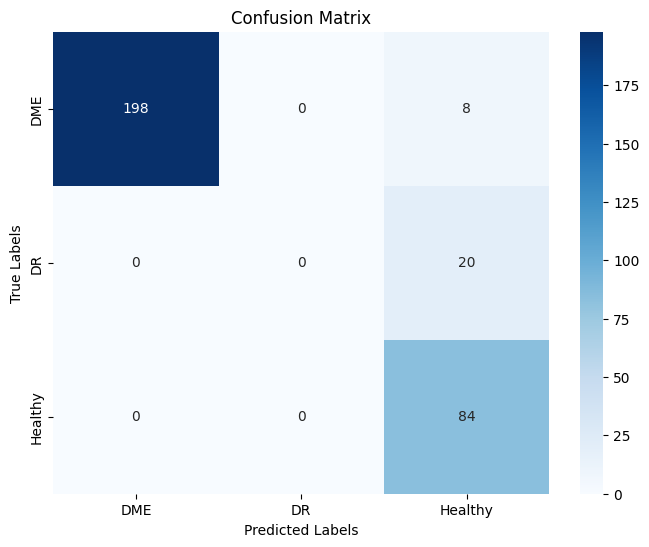

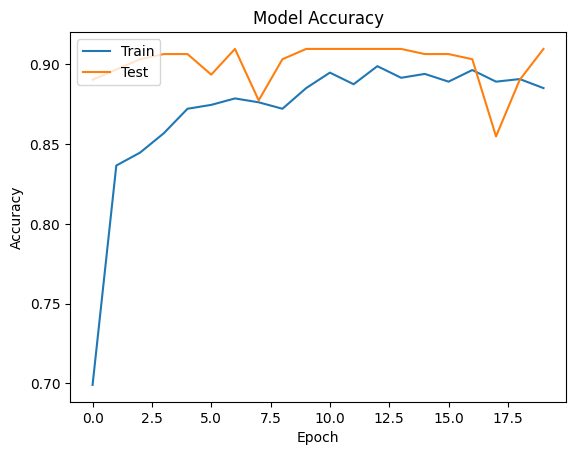

              precision    recall  f1-score   support

         DME       1.00      0.96      0.98       206
          DR       0.00      0.00      0.00        20
     Healthy       0.75      1.00      0.86        84

    accuracy                           0.91       310
   macro avg       0.58      0.65      0.61       310
weighted avg       0.87      0.91      0.88       310



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set the paths to your dataset
dataset_path = '/content/drive/MyDrive/RISC2023/OCT-AND-EYE-FUNDUS-DATASET/OCT-AND-EYE-FUNDUS-DATASET-main/fundus'
dme_path = os.path.join(dataset_path, 'fundus_DME')
dr_path = os.path.join(dataset_path, 'fundus_DR')
healthy_path = os.path.join(dataset_path, 'fundus_HEALTHY')

# Set the image dimensions
image_width, image_height = 256, 256

# Load the images and labels
images = []
labels = []

for class_path, class_label in [(dme_path, 0), (dr_path, 1), (healthy_path, 2)]:
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (image_width, image_height))
        images.append(image)
        labels.append(class_label)

# Convert the data to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Perform train-test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(train_images)

# Convert labels to one-hot encoded vectors
num_classes = 3
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Define the multi-scale attention network
input_tensor = Input(shape=(image_width, image_height, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x_before_pooling = Conv2D(512, (3, 3), activation='relu')(x)
attention = GlobalAveragePooling2D()(x_before_pooling)
attention = Dense(256)(attention)
attention = Activation('relu')(attention)
attention = Dense(1)(attention)
attention = Activation('softmax')(attention)
attention = Flatten()(attention)
attention = Multiply()([x_before_pooling, attention])

# Create the model
x = GlobalAveragePooling2D()(attention)
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(test_images, test_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels
class_labels = ['DME', 'DR', 'Healthy']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)


In [7]:
# Save the model as an .h5 file
# Save the model as an .h5 file
model.save('/content/drive/MyDrive/concatcheck/fundusmsan.h5')




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
